In [2]:
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast,
                          BertForMaskedLM, BertTokenizerFast,
                          DistilBertForMaskedLM, DistilBertTokenizerFast,
                          RobertaForMaskedLM, RobertaTokenizerFast,
                          BlenderbotForCausalLM, BlenderbotTokenizer,
                          BigBirdForMaskedLM, BigBirdTokenizer,
                          ElectraForMaskedLM, ElectraTokenizerFast)
from multiprocessing import Pool
import pandas as pd
import glob
from itertools import product
import seaborn as sns
from matplotlib import pyplot as plt

In [1]:
from lmeval.datasets import NarrativesDataset
from lmeval.engine import StridingMLM, StridingForwardLM

### Initialize list of models and parameters

Some notes on the metrics:
- Loss: quantifies distance from real predictions [NS]
- Probability true: quantifies accuracy in terms of probability attributed to the predicted word (inverse is surprisal) [NS]
- Probability top: reference for probability true - **should maybe replace with rank!**
- Entropy: quantifies uncertainty of the model over next-word prediction [NS]
- Top true: quantifies general model accuracy as "is the top prediction the correct one"?
- nr unique words / vocabulary size: quantifies how "varied" model predictions are

Need to define:
- Random baseline

Questions:
- Which model is the most accurate, in terms of cross-entropy loss, probability true, and probability top?
- Which window yield the best predictions?
- What type of text yields the best predictions?

Additional to dos:
- Qualitative inspection of the data

In [3]:
transcripts = glob.glob('inputs/narratives/gentle/*/transcript*')
aligned = glob.glob('inputs/narratives/gentle/*/align.csv')
dataset_files = transcripts + aligned

In [4]:
model_classes = [GPT2LMHeadModel,
                 BertForMaskedLM,
                 DistilBertForMaskedLM, 
                 RobertaForMaskedLM, 
                 BlenderbotForCausalLM, 
                 BigBirdForMaskedLM,
                 ElectraForMaskedLM]
model_ids = ['gpt2', 
             'bert-base-uncased', 
             'distilbert-base-uncased',
             'roberta-base', 
             'facebook/blenderbot-400M-distill', 
             'google/bigbird-roberta-base', 
             'google/electra-base-discriminator']
tokenizer_classes = [GPT2TokenizerFast,
                     BertTokenizerFast,
                     DistilBertTokenizerFast,
                     RobertaTokenizerFast,
                     BlenderbotTokenizer,
                     BigBirdTokenizer,
                     ElectraTokenizerFast]
model_parameters = list(zip(model_classes, model_ids, tokenizer_classes))

In [5]:
ctx_lengths = [5, 10, 15, 20]

Create all combinations of files, model_parameters, and context lengths

In [6]:
parameters = list(product(dataset_files, 
                          model_parameters, 
                          ctx_lengths))
parameters = [(i[0], *i[1], i[2]) for i in parameters]

### Define validation function + utils

In [7]:
def _make_dataset_id(datafile):
    ds_name_splits = datafile.split('/')
    narrative = ds_name_splits[3]
    ds_type = ds_name_splits[-1].split('.')[0]
    ds_id = '_'.join([narrative, ds_type])
    return ds_id

In [8]:
def _validate(datafile, model_class, model_id, tokenizer_class, ctx_length):
    tokenizer = tokenizer_class.from_pretrained(model_id)
    model = model_class.from_pretrained(model_id)
    dataset_name = _make_dataset_id(datafile)
    data = NarrativesDataset(datafile, dataset_name)
    data.text = data.text[:100]
    if any([b in model_id for b in ['bert','electra',
                                    'bigbird']]):
        engine = StridingMLM(context_length=ctx_length)
    else:
        engine = StridingForwardLM(context_length=ctx_length)
    result = engine.run(data, tokenizer, model, model_id)
    return result

### Run in parallel

In [ ]:
for p in parameters:
    _validate(*p)

In [ ]:
pool = Pool(2)

In [61]:
results = pool.starmap(_validate, parameters)
pool.close()

## Read in data and plot

In [3]:
logs = glob.glob('outputs/*/*')

In [4]:
for l in logs:
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)

In [5]:
import numpy as np
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log(all_logs['prob_true'])

In [36]:
dct[c]

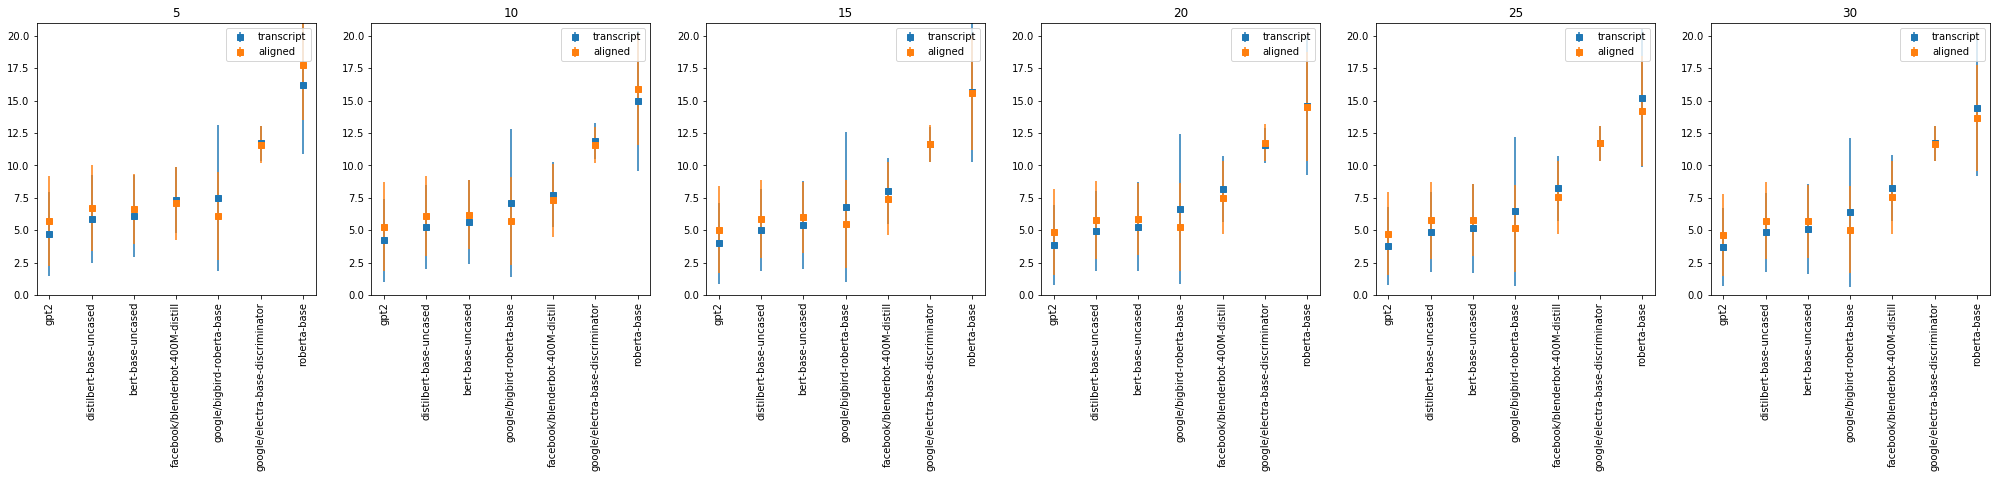

In [44]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).loss.agg(['mean', 'std']).reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'mean_loss', 'std_loss']
log_mean = log_mean.sort_values(by='mean_loss')
f, ax = plt.subplots(figsize=(35,5), nrows=1, ncols=6)
dct = dict(zip(sorted(log_mean.context_size.unique().tolist()),
               ax))
for idx, c in enumerate(log_mean.context_size.unique()):
    for t in log_mean.type.unique():
        dct[c].errorbar(data=log_mean[(log_mean['context_size']==c) & \
                                      (log_mean['type']==t)], 
                     x='model', 
                     y='mean_loss', 
                     yerr='std_loss', 
                        label=t, ls='none', marker='s')
        for tick in dct[c].get_xticklabels():
            tick.set_rotation(90)
        dct[c].set_ylim(0,21)
        dct[c].set_title(f'Loss: {c}')
        dct[c].legend()
        #dct[c].set_xticklabels(labels=dct[c].get_xticklabels(), 
        #                        rotation=90)
    #plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


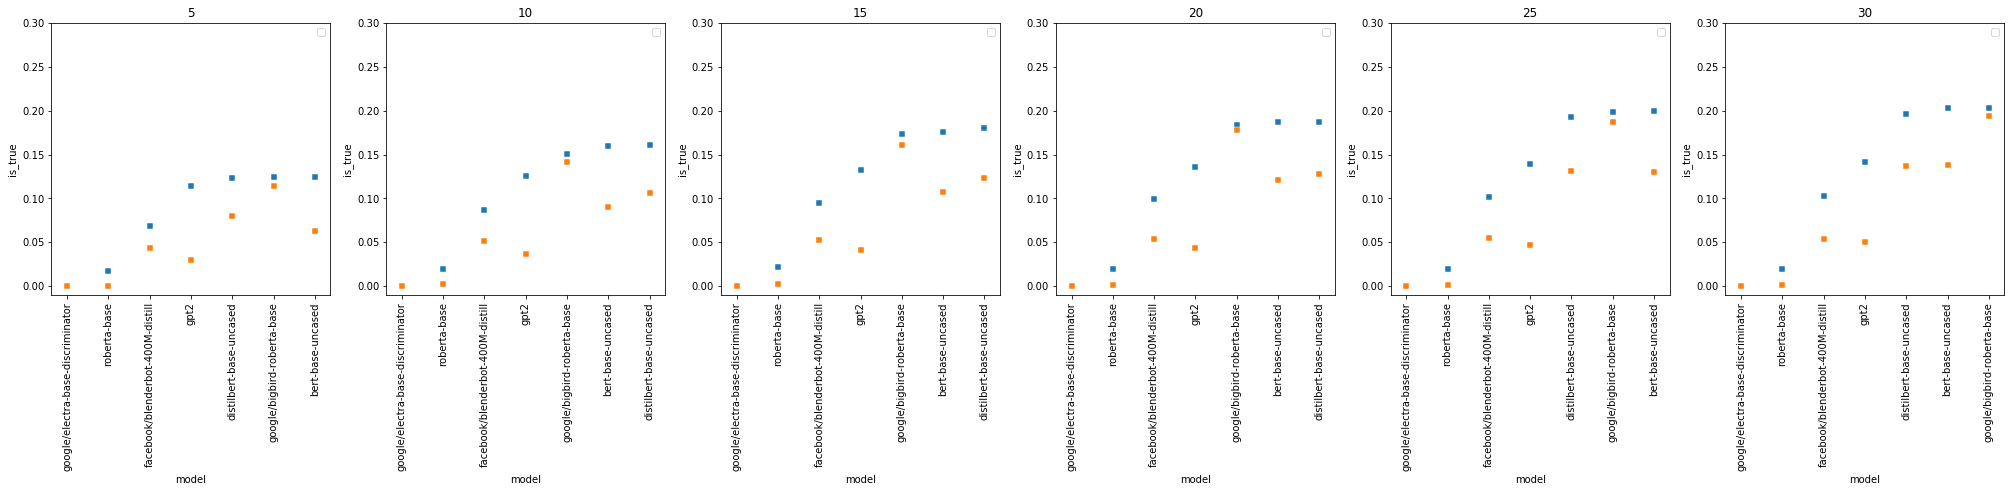

In [118]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).is_true.agg(['mean', 'std']).reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'is_true', 'std_loss']
log_mean = log_mean.sort_values(by='is_true')
f, ax = plt.subplots(figsize=(35,5), nrows=1, ncols=6)
dct = dict(zip(sorted(log_mean.context_size.unique().tolist()),
               ax))
for idx, c in enumerate(log_mean.context_size.unique()):
    for t in log_mean.type.unique():
        sns.scatterplot(data=log_mean[(log_mean['context_size']==c) & \
                                      (log_mean['type']==t)], 
                     x='model', 
                     y='is_true', 
                     marker='s', 
                     ax=dct[c])
        for tick in dct[c].get_xticklabels():
            tick.set_rotation(90)
        dct[c].set_ylim(-0.01,.30)
        dct[c].set_title(f'Probability true: {c}')
        dct[c].legend()
        #dct[c].set_xticklabels(labels=dct[c].get_xticklabels(), 
        #                        rotation=90)
    #plt.show()

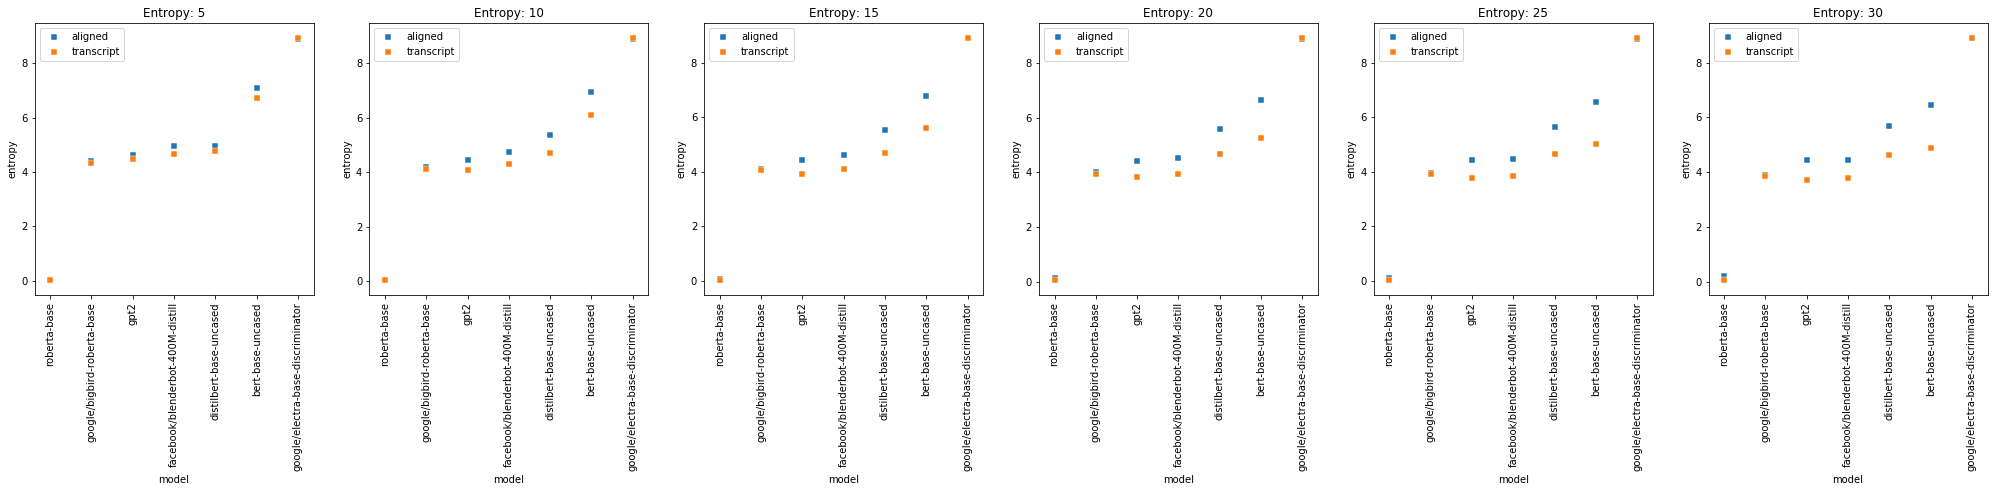

In [126]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).entropy.agg(['mean', 'std']).reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'entropy', 'std_loss']
log_mean = log_mean.sort_values(by='entropy')
f, ax = plt.subplots(figsize=(35,5), nrows=1, ncols=6)
dct = dict(zip(sorted(log_mean.context_size.unique().tolist()),
               ax))
for idx, c in enumerate(log_mean.context_size.unique()):
    for t in log_mean.type.unique():
        sns.scatterplot(data=log_mean[(log_mean['context_size']==c) & \
                                      (log_mean['type']==t)], 
                         x='model', 
                         y='entropy', 
                         marker='s', 
                         ax=dct[c], 
                         label=t)
        for tick in dct[c].get_xticklabels():
            tick.set_rotation(90)
        dct[c].set_title(f'Entropy: {c}')

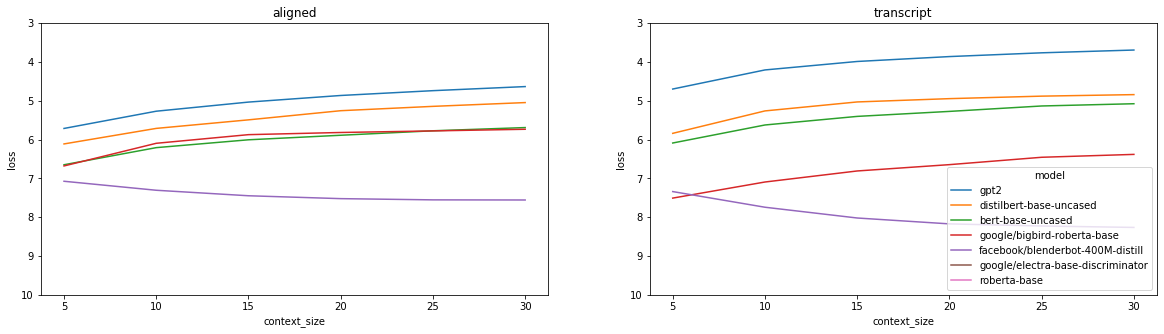

In [98]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).loss.agg('mean').reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'loss']
log_mean = log_mean.sort_values(by='loss')
f, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.lineplot(data=log_mean[log_mean['type']=='aligned'], 
             x='context_size', 
             y='loss', 
             hue='model', ax=ax[0], legend=False)
ax[0].set_ylim(10,3)
ax[0].set_title('aligned')
sns.lineplot(data=log_mean[log_mean['type']=='transcript'], 
             x='context_size', 
             y='loss', 
             hue='model', ax=ax[1])
ax[1].set_ylim(10,3)
ax[1].set_title('transcript')
plt.show()

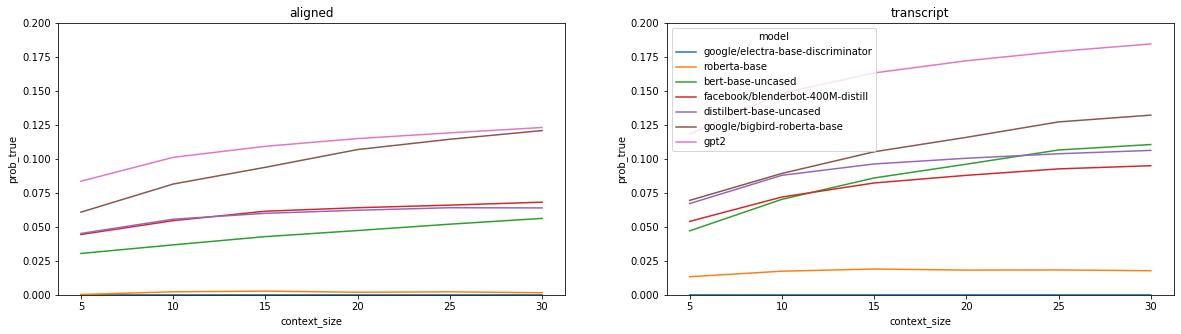

In [99]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).prob_true.agg('mean').reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'prob_true']
log_mean = log_mean.sort_values(by='prob_true')
f, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.lineplot(data=log_mean[log_mean['type']=='aligned'], 
             x='context_size', 
             y='prob_true', 
             hue='model', ax=ax[0], legend=False)
ax[0].set_ylim(0,.2)
ax[0].set_title('aligned')
sns.lineplot(data=log_mean[log_mean['type']=='transcript'], 
             x='context_size', 
             y='prob_true', 
             hue='model', ax=ax[1])
ax[1].set_ylim(0,.2)
ax[1].set_title('transcript')
plt.show()

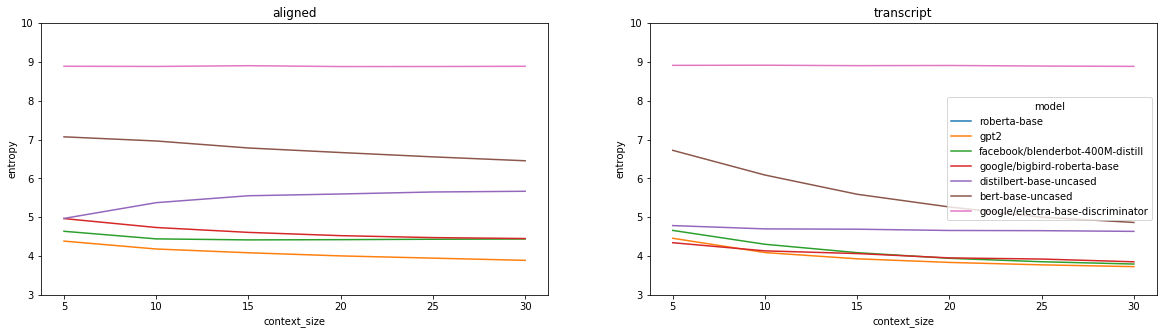

In [104]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).entropy.agg('mean').reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'entropy']
log_mean = log_mean.sort_values(by='entropy')
f, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.lineplot(data=log_mean[log_mean['type']=='aligned'], 
             x='context_size', 
             y='entropy', 
             hue='model', ax=ax[0], legend=False)
ax[0].set_ylim(3,10)
ax[0].set_title('aligned')
sns.lineplot(data=log_mean[log_mean['type']=='transcript'], 
             x='context_size', 
             y='entropy', 
             hue='model', ax=ax[1])
ax[1].set_ylim(3,10)
ax[1].set_title('transcript')
plt.show()

### Qualitative analyses

- Check distribution of top predicted;
- Check counts of what is predicted most often by each model;
- Compare across types;

In [ ]:
# To dos